## Libraries Imported

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


## Data Collection and Preprocessing

In [2]:
# Paths for image storage
georges_dir = 'georges/'
non_georges_dir = 'non_georges'

# Create directories if they don't exist
os.makedirs(georges_dir, exist_ok=True)
os.makedirs(non_georges_dir, exist_ok=True)

# Load CSV files for images
georges_csv = pd.read_csv('georges.csv', header=None, names=['url'])
non_georges_csv = pd.read_csv('non_georges.csv', header=None, names=['url'])

def download_images(df, folder):
    """ Download images from a dataframe with URLs and save them into a folder. """
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Downloading images to {folder}"):
        url = row['url']
        try:
            response = requests.get(url, timeout=10)
            image = Image.open(BytesIO(response.content))
            image_path = os.path.join(folder, f"{idx}.jpg")
            image.save(image_path)
        except Exception as e:
            print(f"Failed to load image from URL: {url} due to {e}")

In [1]:
# Download images for each category
download_images(georges_csv, georges_dir)
download_images(non_georges_csv, non_georges_dir)

In [3]:
base_dir = './data/'

## Model Selection: EfficientNet-B0

c:\Users\atulp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\atulp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1: 100%|██████████| 152/152 [05:16<00:00,  2.08s/it]


Epoch 1: Train Loss: 0.3637, Train Accuracy: 84.83%
Epoch 1: Validation Loss: 0.2302, Validation Accuracy: 91.24%


Training Epoch 2: 100%|██████████| 152/152 [04:45<00:00,  1.88s/it]


Epoch 2: Train Loss: 0.2243, Train Accuracy: 91.42%
Epoch 2: Validation Loss: 0.2651, Validation Accuracy: 90.25%


Training Epoch 3: 100%|██████████| 152/152 [04:45<00:00,  1.88s/it]


Epoch 3: Train Loss: 0.1799, Train Accuracy: 93.34%
Epoch 3: Validation Loss: 0.2634, Validation Accuracy: 92.15%


Training Epoch 4: 100%|██████████| 152/152 [04:46<00:00,  1.89s/it]


Epoch 4: Train Loss: 0.1678, Train Accuracy: 94.00%
Epoch 4: Validation Loss: 0.2416, Validation Accuracy: 91.40%


Training Epoch 5: 100%|██████████| 152/152 [04:36<00:00,  1.82s/it]


Epoch 5: Train Loss: 0.1326, Train Accuracy: 95.74%
Epoch 5: Validation Loss: 0.3231, Validation Accuracy: 90.66%


Training Epoch 6: 100%|██████████| 152/152 [04:40<00:00,  1.85s/it]


Epoch 6: Train Loss: 0.1346, Train Accuracy: 94.87%
Epoch 6: Validation Loss: 0.2574, Validation Accuracy: 92.07%
Early stopping triggered


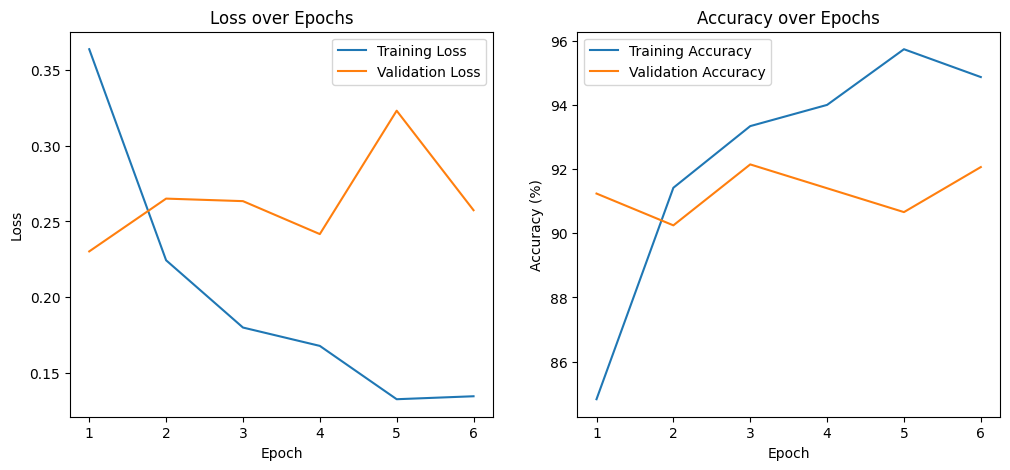

In [4]:


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset from the image directories
data_dir = base_dir
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained EfficientNet model for image classification
model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

device = torch.device("cuda")
model.to(device)

# Define the optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, patience=3):
    """ Function to train and validate the model with early stopping and visualization of metrics. """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * total_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Epoch {epoch+1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Update the learning rate
        scheduler.step()

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered")
                break

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

# Train the model with the scheduler
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

## Model Evaluation and Inference

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model performance on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report and confusion matrix
    print("Classification Report:")
    # Corrected target names based on label assignment (0 -> George, 1 -> Non-George)
    print(classification_report(all_labels, all_preds, target_names=['George', 'Non-George']))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Evaluate the model
evaluate_model(model, val_loader)

# Function to predict on a new image
def predict_image(image_path, model):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # Ensure prediction matches label mapping (0 -> George, 1 -> Non-George)
    return "St. George is present" if predicted.item() == 0 else "St. George is not present"




100%|██████████| 38/38 [00:11<00:00,  3.24it/s]

Classification Report:
              precision    recall  f1-score   support

      George       0.93      0.89      0.91       539
  Non-George       0.91      0.94      0.93       671

    accuracy                           0.92      1210
   macro avg       0.92      0.92      0.92      1210
weighted avg       0.92      0.92      0.92      1210

Confusion Matrix:
[[480  59]
 [ 37 634]]


In [8]:
# Print the class-to-label mapping
print(full_dataset.class_to_idx)


{'georges': 0, 'non_georges': 1}


In [10]:
# Test inference with a new image
image_path = 'path-to-your-image.jpg'
print(predict_image(image_path, model))

St. George is not present


In [12]:
# Test inference with a new image
image_path = 'path-to-your-image.jpg'
print(predict_image(image_path, model))

St. George is present
